# GAN Architecture with Attention -- Tensorflow implementation - CELEB FACES

PENDING
- which losses for intermediary (approx) network?
- size of filter is weird

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle
import os
from pathlib import Path
import tensorflow as tf

from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
faces_mask_path = Path('./datasets/faces_pp/faces_masks.pickle')
faces_original_path = Path('./datasets/faces_pp/faces_original.pickle')
faces_filter_path = Path('./datasets/faces_pp/faces_filter.pickle')

In [3]:
with open(faces_mask_path, 'rb') as file:
    X_mask = pickle.load(file)
    
print(X_mask.shape)

(3000, 3, 128, 128)


In [4]:
with open(faces_original_path, 'rb') as file:
    X_original = pickle.load(file)
    
print(X_original.shape)

(3000, 3, 128, 128)


In [5]:
with open(faces_filter_path, 'rb') as file:
    X_filter = pickle.load(file)
    
print(X_filter.shape)

(3000, 3, 128, 128)


In [6]:
def load_data(X_original_, X_mask_, X_filter_, n_inf, n_sup):
    X_image, X_mask, X_filt = X_original_[n_inf:n_sup], X_mask_[n_inf:n_sup], X_filter_[n_inf:n_sup]
    X_image = X_image.transpose((0, 2, 3, 1))
    X_mask = X_mask.transpose((0, 2, 3, 1))
    X_filt = X_filt.transpose((0,2,3,1))
    #X_image = X_image[:, :, :, 0]
    #X_mask = X_mask[:, :, :, 0]
    #X_image = X_image.reshape(X_image.shape[0], -1)
    #X_mask = X_mask.reshape(X_mask.shape[0], -1)
    return (X_image, X_mask, X_filt)

sample_size=1000

X_train, X_train_mask, X_train_filter = [],[],[]
print("Training Set")
X_train, X_train_mask, X_train_filter = load_data(X_original, X_mask, X_filter, 0, sample_size)
print('  image', X_train.shape)
print('  masked image', X_train_mask.shape)
print('  mask filter', X_train_filter.shape)

print("Testing Set")
X_test, X_test_mask, X_test_filter = load_data(X_original, X_mask, X_filter, 1000, 1100)
print('  image', X_test.shape)
print('  masked image', X_test_mask.shape)
print('  mask filter', X_test_filter.shape)

Training Set
  image (1000, 128, 128, 3)
  masked image (1000, 128, 128, 3)
  mask filter (1000, 128, 128, 3)
Testing Set
  image (100, 128, 128, 3)
  masked image (100, 128, 128, 3)
  mask filter (100, 128, 128, 3)


In [ ]:
"""# Concat image and filter mask for other nets architecture
def load_data_concat(X_image, X_mask, X_filt):
    X_concat = np.concatenate([X_image, X_filt], axis=0)
    return X_concat, X_mask

X_train, X_train_mask = load_data_concat(X_train, X_train_mask, X_train_filter)
X_test, X_test_mask = load_data_concat(X_test, X_test_mask, X_test_filter)


print("Training Set")
print('  image + filter', X_train.shape)
print('  masked image', X_train_mask.shape)

print("Testing Set")
print('  image + filter', X_test.shape)
print('  masked image', X_test_mask.shape)"""

# GAN Model

In [7]:
image_size = X_train[0,:,:,:].shape
n_pixels = int(image_size[0]*image_size[1]*image_size[2])

epochs = 30
batch_size = 64

In [8]:
tf.reset_default_graph()

with tf.variable_scope("approx_net"):
    # user inputs
    masked_image_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    mask_filter_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    real_image_targets = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    # reshaping as a long vector (for Dense Net ...)
    masked_image_inputs_r = tf.reshape(masked_image_inputs, shape=(-1,n_pixels))
    
    # First reconstruction net to grossly approximate the masked region
    images = tf.layers.dense(masked_image_inputs_r, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=100) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    reconstructed_images = tf.layers.dense(images, units=n_pixels, activation=tf.nn.sigmoid)
    
    # reshaping as a image format again (for Dense Net ...)
    reconstructed_images = tf.reshape(reconstructed_images, shape=(-1,)+image_size)
    
    
with tf.variable_scope("attention_generator"):
    
    attention_input = tf.multiply(mask_filter_inputs, reconstructed_images) \
                    + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
    #attention_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    attention_input = tf.layers.conv2d(attention_input, filters=18, kernel_size=3, strides=2, padding="same")
    attention_input = tf.layers.conv2d(attention_input, filters=18, kernel_size=3, strides=2, padding="same")
    
    f_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    g_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    
    h_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    attention_map = tf.expand_dims(tf.nn.softmax(tf.reduce_sum(tf.multiply(f_branch, g_branch), axis=3)), 3)
    #, transpose_a=True)#tf.nn.softmax(tf.matmul(f_branch, g_branch, transpose_a=False))
    
    attention_output = tf.multiply(attention_map, h_branch)
    output_images = tf.layers.conv2d_transpose(attention_output, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    output_images = tf.layers.conv2d_transpose(output_images, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    output_images = tf.multiply(mask_filter_inputs, output_images) \
                        + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
    

with tf.variable_scope("discriminator"):
    
    # Labels fake/real
    true_labels = tf.placeholder(tf.float32, shape=[None,2])
    #discriminator_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    discriminator_input = output_images
    
    #if training_generator:
    #    x = output_images
    #else:
    #    x = discriminator_input
        
    x = tf.layers.conv2d(discriminator_input, filters=16, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.flatten(x)
    x = tf.layers.dense(x, units=50, activation=tf.nn.relu)
    class_logits = tf.layers.dense(x, units=2)
    
    
with tf.variable_scope('losses'):
    # Loss is L2 error on the masked region only
    #loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.))
    #L1_loss = tf.reduce_mean(tf.losses.absolute_difference(real_image_targets, reconstructed_images,
    #                                                       scope=mask_filter_inputs==1.))
    
    reco_loss1 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - reconstructed_images)*mask_filter_inputs))
    #reco_loss1 = tf.losses.absolute_difference(real_image_targets*mask_filter_inputs,reconstructed_images*mask_filter_inputs)
    reco_loss2 = tf.reduce_mean(tf.nn.l2_loss(real_image_targets - output_images)) + reco_loss1
    #reco_loss2 = tf.losses.absolute_difference(real_image_targets, output_images) + reco_loss1
    
    perception_loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.)) \
                      -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, output_images, max_val=1.))
    
    # will be fed with both fake/real images only
    d_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="d_loss"))
    #d_loss = tf.reduce_mean(true_labels * tf.log(classify) + (1-true_labels)*tf.log(1-classify)) + 0.1*L1_loss
    # will be fed with both fake/real images only
    g_loss_gan = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, 
                                                                    logits=class_logits,
                                                                    name="g_loss"))
    g_loss_reco = reco_loss2
    #g_loss = 0*g_loss_gan + 1*g_loss_reco
    g_loss = perception_loss
    
with tf.variable_scope('Optimizer'):
    
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # G Training
    vars_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "approx_net") + \
             tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "attention_generator")
    train_op_g = optimizer_g.minimize(g_loss, var_list=vars_g)
    
    # D Training
    vars_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
    train_op_d = optimizer_d.minimize(d_loss, var_list=vars_d)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [9]:
# /!\/!\/!\/!\/!\
sess_gan = tf.Session()
    
sess_gan.run(tf.global_variables_initializer())
# /!\/!\/!\/!\/!\

history = {'loss_g':[], 'loss_d':[], 'loss_perception':[]}

In [10]:
saver = tf.train.Saver()
#saver.restore(sess_gan, "./model.ckpt")
#print("GAN model restored.")
from tqdm import *
for epoch in tqdm(range(epochs)):
    for i in tqdm(range(X_train.shape[0] // batch_size)):
        
        # load batch_size fake images
        idx = np.random.randint(0, sample_size, batch_size)
        fake_images_mask = X_train_mask[idx]
        fake_images_filter = X_train_filter[idx]
        feed_dict = {masked_image_inputs: fake_images_mask,
                     mask_filter_inputs: fake_images_filter}
        fake_images = sess_gan.run(output_images, feed_dict=feed_dict)
        
        # load batch_size real images
        idx = np.random.randint(0, sample_size, batch_size)
        real_images = X_train[idx]
        real_images_mask = X_train_mask[idx]
        real_images_filter = X_train_filter[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        input_masks = np.concatenate([real_images_mask, fake_images_mask])
        input_filters = np.concatenate([real_images_filter, fake_images_filter])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input: input_images,
                     mask_filter_inputs: input_filters,
                     real_image_targets: input_images,
                     true_labels: labels}
        _, train_loss_d = sess_gan.run([train_op_d, d_loss], feed_dict=feed_dict)

        # Freeze D and train Generator
        idx = np.random.randint(0, sample_size, batch_size)
        labels = np.zeros((batch_size, 2))
        labels[:, 1] = 1.
        feed_dict = {discriminator_input: X_train_mask[idx], # not matter what
                     masked_image_inputs: X_train_mask[idx],
                     mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx],
                     true_labels: labels}
        _, train_loss_g = sess_gan.run([train_op_g, g_loss], feed_dict=feed_dict)
        
        
        history['loss_g'].append(train_loss_g)
        history['loss_d'].append(train_loss_d)
    
    if epoch % 1 == 0:
        feed_dict = {masked_image_inputs: X_test_mask,
                     mask_filter_inputs: X_test_filter,
                     real_image_targets: X_test}
        test_perception_loss = sess_gan.run(perception_loss, feed_dict=feed_dict)
        print("Step {0}/{1} \ttrain D loss: {2} \ttrain G loss {3}"\
              .format(epoch, epochs, train_loss_d, train_loss_g, test_perception_loss))
        history['loss_perception'].append(test_perception_loss)
        save_path = saver.save(sess_gan, "./model.ckpt")
        print("GAN model saved in path: %s" % save_path)

100%|██████████| 15/15 [04:44<00:00, 18.63s/it]

Step 0/30 	train D loss: 0.6939678192138672 	train G loss -0.9708902835845947


  0%|          | 0/15 [00:00<?, ?it/s]

GAN model saved in path: ./model.ckpt



100%|██████████| 15/15 [04:27<00:00, 17.23s/it]

Step 1/30 	train D loss: 0.7008653879165649 	train G loss -0.9756847023963928


  0%|          | 0/15 [00:00<?, ?it/s]

GAN model saved in path: ./model.ckpt



 47%|████▋     | 7/15 [02:03<02:24, 18.02s/it]

KeyboardInterrupt: 

In [11]:
"""       
        # boolean, True if we are training G
        #training_generator = False
        
        # load batch_size fake images
        idx = np.random.randint(0, sample_size, batch_size)
        fake_images_mask = X_train_mask[idx]
        fake_images_filter = X_train_filter[idx]
        feed_dict = {masked_image_inputs: fake_images_mask,
                     mask_filter_inputs: fake_images_filter}
        fake_images = sess_gan.run(output_images, feed_dict=feed_dict)
        
        # load batch_size real images
        idx = np.random.randint(0, sample_size, batch_size)
        real_images = X_train[idx]
        real_images_mask = X_train_mask[idx]
        real_images_filter = X_train_filter[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        input_masks = np.concatenate([real_images_mask, fake_images_mask])
        input_filters = np.concatenate([real_images_filter, fake_images_filter])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input: input_images,
                     mask_filter_inputs: input_filters,
                     real_image_targets: input_images,
                     true_labels: labels}
        _, train_loss_d = sess_gan.run([train_op_d, d_loss], feed_dict=feed_dict)

        #training_generator = True
"""     

'       \n        # boolean, True if we are training G\n        #training_generator = False\n        \n        # load batch_size fake images\n        idx = np.random.randint(0, sample_size, batch_size)\n        fake_images_mask = X_train_mask[idx]\n        fake_images_filter = X_train_filter[idx]\n        feed_dict = {masked_image_inputs: fake_images_mask,\n                     mask_filter_inputs: fake_images_filter}\n        fake_images = sess_gan.run(output_images, feed_dict=feed_dict)\n        \n        # load batch_size real images\n        idx = np.random.randint(0, sample_size, batch_size)\n        real_images = X_train[idx]\n        real_images_mask = X_train_mask[idx]\n        real_images_filter = X_train_filter[idx]\n        \n        # concatenate and label fake/real\n        input_images = np.concatenate([real_images, fake_images])\n        input_masks = np.concatenate([real_images_mask, fake_images_mask])\n        input_filters = np.concatenate([real_images_filter, fake_ima

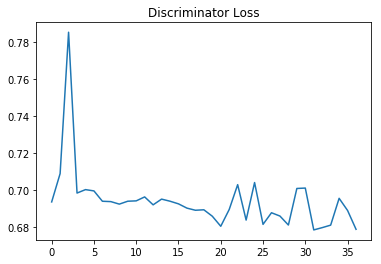

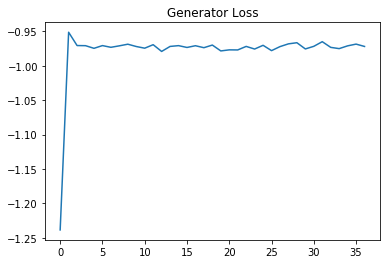

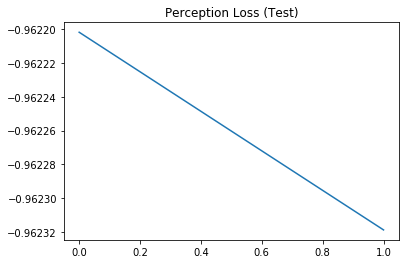

In [12]:
plt.plot(history['loss_d'])
plt.title("Discriminator Loss")
plt.show()

plt.plot(history['loss_g'])
plt.title("Generator Loss")
plt.show()

plt.plot(history['loss_perception'])
plt.title("Perception Loss (Test)")
plt.show()

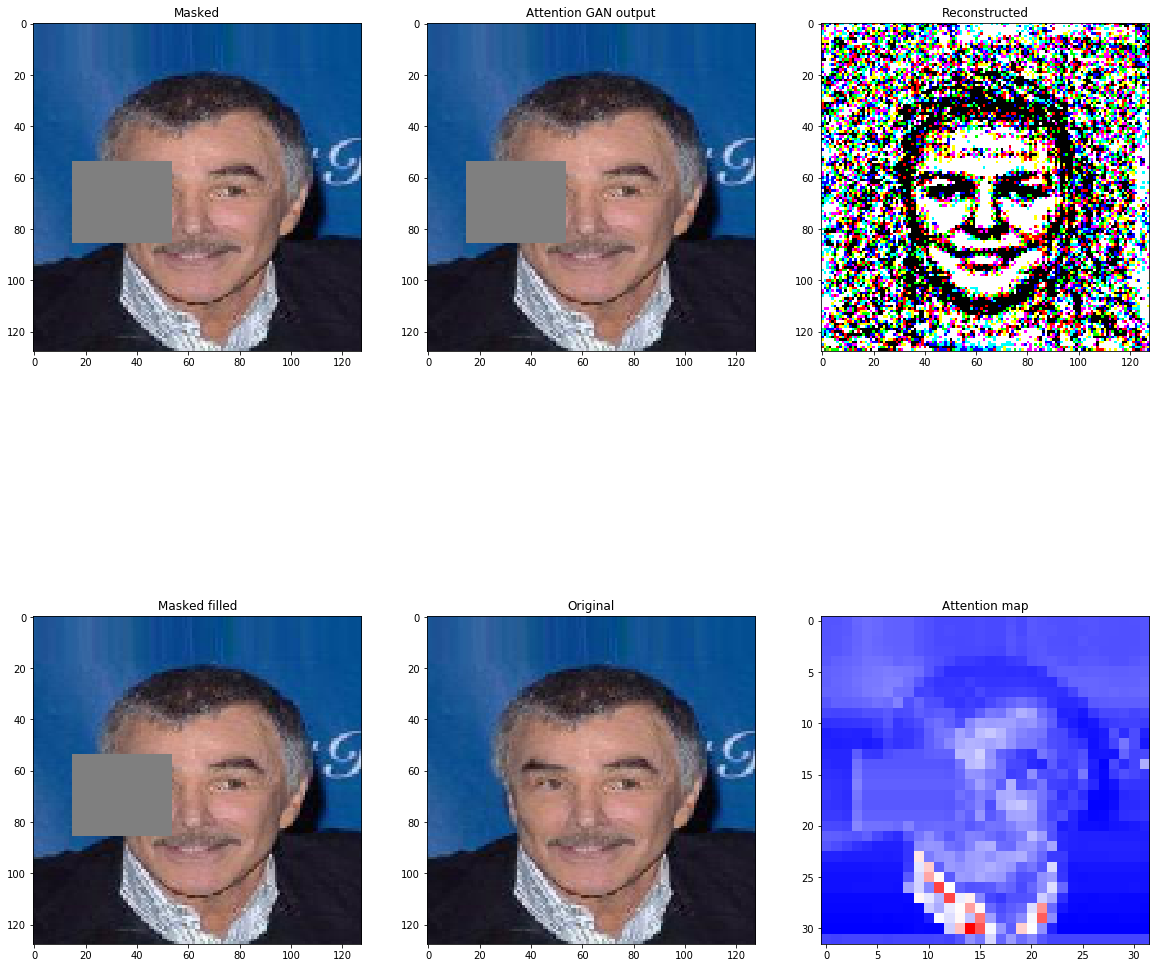

In [16]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, out_imgs = sess_gan.run([reconstructed_images, attention_map, output_images], 
                                             feed_dict=feed_dict)

i = 40
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.subplot(2, 3, 4)
plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Masked filled")
plt.subplot(2, 3, 2)
plt.imshow(out_imgs[i])
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i].reshape(32, 32), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_test[i])
plt.title("Original")

plt.show()

# No-GAN Model

In [ ]:
image_size = (64, 64, 3)
n_pixels = int(image_size[0]*image_size[1]*image_size[2])

epochs = 25
batch_size = 64

In [ ]:
tf.reset_default_graph()

with tf.variable_scope("approx_net"):
    # user inputs
    masked_image_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    mask_filter_inputs = tf.placeholder(tf.float32, shape=(None,)+image_size)
    real_image_targets = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    # reshaping as a long vector (for Dense Net ...)
    masked_image_inputs_r = tf.reshape(masked_image_inputs, shape=(-1,n_pixels))
    
    # First reconstruction net to grossly approximate the masked region
    images = tf.layers.dense(masked_image_inputs_r, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=100) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    images = tf.layers.dense(images, units=512) 
    images = tf.nn.leaky_relu(images, alpha=0.2)
    
    reconstructed_images = tf.layers.dense(images, units=n_pixels, activation=tf.nn.sigmoid)
    
    # reshaping as a image format again (for Dense Net ...)
    reconstructed_images = tf.reshape(reconstructed_images, shape=(-1,)+image_size)
    
    
with tf.variable_scope("attention_generator"):
    
    attention_input = tf.multiply(mask_filter_inputs, reconstructed_images) \
                    + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
    #attention_input = tf.placeholder(tf.float32, shape=(None,)+image_size)
    
    attention_input = tf.layers.conv2d(attention_input, filters=18, kernel_size=3, strides=2, padding="same")
    attention_input = tf.layers.conv2d(attention_input, filters=18, kernel_size=3, strides=2, padding="same")
    
    f_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    g_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    
    h_branch = tf.layers.conv2d(attention_input, filters=48, kernel_size=1, padding="same")
    attention_map = tf.expand_dims(tf.nn.softmax(tf.reduce_sum(tf.multiply(f_branch, g_branch), axis=3)), 3)
    #, transpose_a=True)#tf.nn.softmax(tf.matmul(f_branch, g_branch, transpose_a=False))
    
    attention_output = tf.multiply(attention_map, h_branch)
    output_images = tf.layers.conv2d_transpose(attention_output, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    output_images = tf.layers.conv2d_transpose(output_images, filters=3, kernel_size=3, strides=2,
                                               padding="same", activation=tf.nn.sigmoid)
    

"""with tf.variable_scope("discriminator"):
    
    discriminator_input = tf.multiply(mask_filter_inputs, output_images) \
                        + tf.multiply(1-mask_filter_inputs, masked_image_inputs)  
        
    x = tf.layers.conv2d(discriminator_input, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters=256, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    reshape = tf.reshape(x, [batch_size, -1])
    classify = tf.layers.dense(reshape, 2, activation=tf.nn.sigmoid)"""
    
    
with tf.variable_scope('losses'):
    # Loss is L2 error on the masked region only
    #loss = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.))
    #reco_loss1 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - reconstructed_images)*mask_filter_inputs))
    reco_loss1 = tf.losses.absolute_difference(real_image_targets*mask_filter_inputs,reconstructed_images*mask_filter_inputs)
    #reco_loss2 = tf.reduce_mean(tf.nn.l2_loss((real_image_targets - output_images)*mask_filter_inputs)) + reco_loss1
    
    reco_loss2 = -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, reconstructed_images, max_val=1.)) \
                 -1 * tf.reduce_mean(tf.image.ssim(real_image_targets, output_images, max_val=1.))
    
with tf.variable_scope('Optimizer'):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # To train the approx net only
    vars_approx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "approx_net")
    train_op_approx = optimizer.minimize(reco_loss1, var_list=vars_approx)
    # To train the attention only
    vars_attention = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "attention_generator")
    train_op_attention = optimizer.minimize(reco_loss2)#, var_list=vars_attention)
    

In [ ]:
# /!\/!\/!\/!\/!\
sess = tf.Session()
    
sess.run(tf.global_variables_initializer())
# /!\/!\/!\/!\/!\

In [ ]:
for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        # Draw a random batch and train on it
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        feed_dict = {masked_image_inputs: X_train_mask[idx],
                     mask_filter_inputs: X_train_filter[idx],
                     real_image_targets: X_train[idx]}
        _, train_loss = sess.run([train_op_approx, reco_loss1], feed_dict=feed_dict)
        #_, train_loss = sess.run([train_op_attention, reco_loss2], feed_dict=feed_dict)
    if epoch % 1 == 0:
        feed_dict = {masked_image_inputs: X_test_mask,
                     mask_filter_inputs: X_test_filter,
                     real_image_targets: X_test}
        test_loss = sess.run(reco_loss1, feed_dict=feed_dict)
        print("Step {0}/{1} \ttrain loss: {2} \ttest loss {3}".format(epoch, epochs, train_loss, test_loss))
        #if epoch % 10 == 0:
        #    reco_imgs = sess.run(reconstructed_images, feed_dict=feed_dict)
        #    i = 3
        #    plt.imshow(X_test_mask[i])
        #    plt.show()
        #    plt.imshow(reco_imgs[i])
        #    plt.show()
        #    plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
        #    plt.show()
        #    plt.imshow(X_test[i])
        #   plt.show()

In [ ]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, out_imgs = sess.run([reconstructed_images, attention_map, output_images], 
                                        feed_dict=feed_dict)

i = 99
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.show()
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.show()
plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Masked filled")
plt.show()
plt.imshow(X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Attention GAN output")
plt.show()
plt.imshow(att_map[i].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.show()
plt.imshow(X_test[i])
plt.title("Original")
plt.show()

In [ ]:
feed_dict = {masked_image_inputs: X_test_mask,
             mask_filter_inputs: X_test_filter,
             real_image_targets: X_test}

reco_imgs, att_map, out_imgs = sess.run([reconstructed_images, attention_map, output_images], 
                                        feed_dict=feed_dict)

i = 5
plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(X_test_mask[i])
plt.title("Masked")
plt.subplot(2, 3, 3)
plt.imshow(reco_imgs[i])
plt.title("Reconstructed")
plt.subplot(2, 3, 4)
plt.imshow(X_test_filter[i]*reco_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Masked filled")
plt.subplot(2, 3, 2)
plt.imshow(X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.title("Attention GAN output")
plt.subplot(2, 3, 6)
plt.imshow(att_map[i].reshape(16, 16), cmap='bwr', interpolation='nearest')
plt.title("Attention map")
plt.subplot(2, 3, 5)
plt.imshow(X_test[i])
plt.title("Original")

plt.show()

In [ ]:
feed_dict2 = {attention_input: reconstructed_images}

sess.run(output_images, feed_dict=feed_dict2)

# Sandbox Zone

In [ ]:
#img1 = tf.Variable(X_train[0].transpose(1, 2, 0))
#img2 = tf.Variable(X_train[0].transpose(1, 2, 0))
img1 = tf.placeholder(tf.float32, shape=(64, 64, 3))
img2 = tf.placeholder(tf.float32, shape=(64, 64, 3))
max_val = 1.

In [ ]:
similarity = tf.image.ssim(img1, img2, max_val=1.)

with tf.Session() as sess:
    #print(sess.run(similarity, feed_dict={img1:X_train[0], img2:X_train_mask[0]}))
    print(sess.run(-similarity, feed_dict={img1:X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i], 
                                          img2:X_test[i]}))

plt.imshow(X_test[i])
plt.show()
plt.imshow(X_test_filter[i]*out_imgs[i] + (1-X_test_filter[i])*X_test_mask[i])
plt.show()

In [ ]:
with tf.Session() as sess:
    z = tf.image.extract_image_patches(tf.expand_dims(img1, 0), 
                                       [1, 8, 8, 1], 
                                       [1, 8, 8, 1], 
                                       [1,1,1,1], 
                                       padding="SAME", 
                                       name=None)
    print(z.shape)

In [ ]:
true_labels2_test = np.array([[1., 1., 0., 0.]])
class_logits2_test = np.array([[60., 60., 14., 14.]])
sess_test = tf.Session()
sess_test.run(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels2_test, logits=class_logits2_test, name="test"))

In [ ]:
true_labels2_test = np.array([[0., 1.],
                              [0., 1.], 
                              [0., 1.], 
                              [0., 1.]])
class_logits2_test = np.array([[20., 18.],
                              [2., 19.], 
                              [1., 21.], 
                              [1., 45.]])
sess_test = tf.Session()
sess_test.run(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels2_test, logits=class_logits2_test, name="test"))

In [ ]:
# --------------- DISCRIMINATOR 2 ----------------- # 

with tf.variable_scope("discriminator2"):
    
    # Labels fake/real
    true_labels2 = tf.placeholder(tf.float32, shape=[None,2])
    discriminator_input2 = tf.placeholder(tf.float32, shape=(None,)+image_size)
        
    x2 = tf.layers.conv2d(discriminator_input2, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.conv2d(x2, filters=32, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.conv2d(x2, filters=64, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.conv2d(x2, filters=128, kernel_size=1, strides=2, padding="same", activation=tf.nn.relu)
    x2 = tf.layers.flatten(x2)
    x2 = tf.layers.dense(x2, units=50, activation=tf.nn.relu)
    #class_logits = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
    class_logits2 = tf.layers.dense(x2, units=2)
    #class_logits2 = tf.squeeze(class_logits2, axis=1)
    
    # Loss function
    d_loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels2, 
                                                                     logits=class_logits2,
                                                                     name="d_loss2"))
    
    # Optimizer
    optimizer_d2 = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5)
    
    # Op
    train_op_d2 = optimizer_d2.minimize(d_loss2)

In [ ]:
epochs = 20
batch_size = 64

for epoch in range(epochs):
    for i in range(X_train.shape[0] // batch_size):
        # load batch_size fake images
        #idx = np.random.randint(0, X_train.shape[0], batch_size)
        #fake_images_mask = X_train_mask[idx]
        #fake_images_filter = X_train_filter[idx]
        #feed_dict = {masked_image_inputs: fake_images_mask,
        #             mask_filter_inputs: fake_images_filter}
        #fake_images = sess_gan.run(discriminator_input, feed_dict=feed_dict)
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        fake_images = X_train_mask[idx] # take masked images
        
        # load batch_size real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # concatenate and label fake/real
        input_images = np.concatenate([real_images, fake_images])
        #labels = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
        labels = np.zeros((2*batch_size, 2))
        labels[batch_size:, 0] = 1.
        labels[:batch_size, 1] = 1.
        
        # Freeze G train Discriminator
        feed_dict = {discriminator_input2: input_images,
                     true_labels2: labels}
        _, train_loss_d2 = sess_gan.run([train_op_d2, d_loss2], feed_dict=feed_dict)
        
        #print(sess_gan.run(class_logits2, feed_dict=feed_dict))
        
    if epoch % 1 == 0:
        print("Step {0}/{1} \ttrain D loss: {2}"\
              .format(epoch, epochs, train_loss_d2))